In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time # 수행시간
# from imblearn.over_sampling import SMOTE  # over_sampling
from sklearn.tree import export_graphviz  # 결정트리 모형
# import graphviz           # 결정트리 모형
from sklearn import tree # 결정트리 모형
# from sklearn.inspection import permutation_importance # feature 중요도

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier #, plot_tree
from sklearn.ensemble import (VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,
                                ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import xgboost as xgb # python wrapper
from xgboost import XGBClassifier  # sklearn wrapper
from lightgbm import LGBMClassifier

import pickle                  # 모델 저장
import matplotlib as mpl       # 한글깨짐
import matplotlib.font_manager as fm # 한글깨짐
import matplotlib.font_manager  # 한글깨짐


In [2]:
df = pd.read_csv('data/NHIS_total_model.csv')
df.head(3)

,기준년도,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),청력(좌),...,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진수검여부
0,2009,2,1,26,145.0,40.0,62.0,1.0,1.0,1.0,...,90.0,12.9,1.0,0.7,22.0,24.0,11.0,1.0,0.0,0.0
1,2009,2,1,11,145.0,40.0,67.0,1.2,1.2,1.0,...,120.0,13.5,1.0,0.5,22.0,16.0,12.0,1.0,0.0,1.0
2,2009,2,1,43,145.0,45.0,64.0,1.5,1.5,1.0,...,124.0,12.8,1.0,1.2,21.0,12.0,10.0,1.0,1.0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9088554 entries, 0 to 9088553
Data columns (total 27 columns):
기준년도           int64
성별코드           int64
연령대코드(5세단위)    int64
시도코드           int64
신장(5Cm단위)      float64
체중(5Kg단위)      float64
허리둘레           float64
시력(좌)          float64
시력(우)          float64
청력(좌)          float64
청력(우)          float64
수축기혈압          float64
이완기혈압          float64
식전혈당(공복혈당)     float64
총콜레스테롤         float64
트리글리세라이드       float64
HDL콜레스테롤       float64
LDL콜레스테롤       float64
혈색소            float64
요단백            float64
혈청크레아티닌        float64
(혈청지오티)AST     float64
(혈청지오티)ALT     float64
감마지티피          float64
흡연상태           float64
음주여부           float64
구강검진수검여부       float64
dtypes: float64(23), int64(4)
memory usage: 1.8 GB


In [4]:
df['기준년도'].value_counts()

2017    981985
2015    981932
2016    980881
2014    980670
2013    978865
2012    973503
2011    965265
2009    963029
2010    961773
2018    320651
Name: 기준년도, dtype: int64

In [5]:
### 2018년도 100만건 자료를 보면 콜레스테롤관련 33만건만 입력되어. notnull filter시 제거되었음 
### 모델링자료는  가능하나, 시각화자료는 연도별 통계가 맞지 않아 2018년은 삭제하여 시각화
# 2018 value_counts()
#  11  청력(우)         999783 non-null   float64
#  12  수축기혈압         994270 non-null   float64
#  13  이완기혈압         994270 non-null   float64
#  14  식전혈당(공복혈당)    994085 non-null   float64
#  15  총콜레스테롤        332756 non-null   float64
#  16  트리글리세라이드      332748 non-null   float64
#  17  HDL콜레스테롤      332746 non-null   float64
#  18  LDL콜레스테롤      325878 non-null   float64
#  19  혈색소           994086 non-null   float64
#  20  요단백           989430 non-null   float64
#  21  혈청크레아티닌       994094 non-null   float64
#  22  (혈청지오티)AST    994094 non-null   float64
#  23  (혈청지오티)ALT    994094 non-null   float64
#  24  감마지티피         994091 non-null   float64
#  25  흡연상태          999766 non-null   float64

In [3]:
df=df[ df['기준년도']  != 2018  ]

In [4]:
# 한글깨짐 linux 
font_dirs = ['/home/sch/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
font_list = fm.createFontList(font_files)
fm.fontManager.ttflist.extend(font_list)
[f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name][:3]

['NanumMyeongjo Eco', 'NanumMyeongjo', 'NanumGothicCoding']

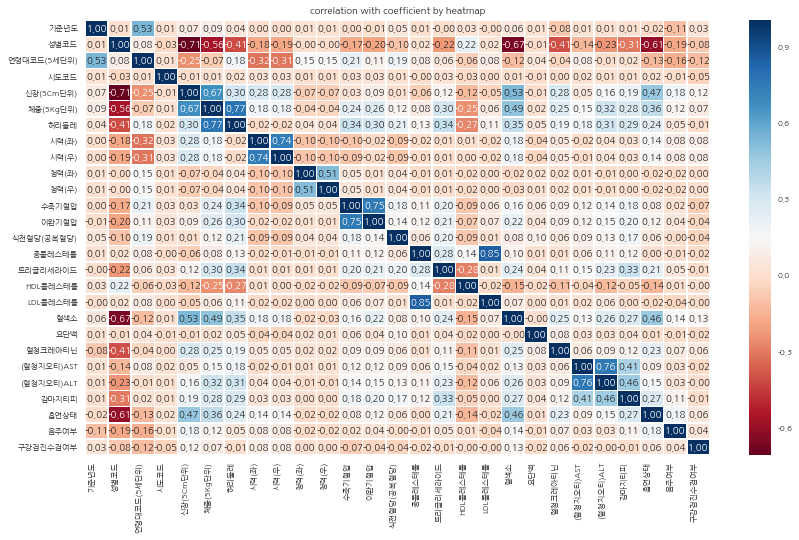

In [5]:
# 전체 상관관계도
def corr_plot(df):
    plt.figure(figsize=(14,8))
    sns.set(font_scale=0.8)
    
#     font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#     mpl.rc('font', family=font_name) 
    
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    
    ax = sns.heatmap(df.corr(), annot = True, fmt = '.2f', linewidths=.5, cmap='RdBu')
    ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='right') 
    plt.title("correlation with coefficient by heatmap")
    #     plt.savefig('./img/corr_plot.png')
    plt.show()
#     plt.close()
corr_plot(df)


#### profile에서 warnings 상관성 

In [ ]:
# ## 산점도, 추세선 lowess
# sns.regplot('총콜레스테롤', 'LDL콜레스테롤', lowess=True, data = df)

In [ ]:
# pairplot + 커널밀도함수로  겹침 ==> 군집화 정도 # 시간이 너무 많이 걸림(feature, data 적은 곳에 )
# def pairplot_(df):     
#     plt.figure(figsize=(14,8))
#     sns.set(font_scale=0.8)
#     g = sns.PairGrid(df)
#     g.map_upper(sns.scatterplot)
#     g.map_diag(sns.distplot, kde=True)
#     # g.map_lower(sns.kdeplot, levels=3, fill=True) # levels 군집화 level
#     g.map_lower(sns.kdeplot, levels=3, fill=True,  height=10, aspect=0.9) # levels 군집화 level # height 
# pairplot_(df)

## visual

#### target target_CAT 생성
* 식전혈당(공복혈당) 3가지로 분류
* 당뇨(>=126), 공복혈당장애(100<= <126) , 정상(<100)

In [6]:
cat_mapping = {
1: "당뇨",
2: "공복혈당장애",
3: "정상"
}

In [7]:
df['target'] = df['식전혈당(공복혈당)'].apply(lambda x: 1 if x >= 126 else ( 2 if 100 <= x < 126 else 3))
df['target'].value_counts()

3    5887395
2    2300741
1     579767
Name: target, dtype: int64

In [8]:
tmp_lst = df['target'].value_counts().values
print(f'당뇨(target) {np.round((tmp_lst[2]/tmp_lst.sum())*100, 2)}%')
print(f'공복혈당장애(target) {np.round((tmp_lst[1]/tmp_lst.sum())*100, 2)}%')
print(f'정상(target) {np.round((tmp_lst[0]/tmp_lst.sum())*100, 2)}%')

당뇨(target) 6.61%
공복혈당장애(target) 26.24%
정상(target) 67.15%


In [9]:
df['target_CAT'] = df['target'].map(cat_mapping)

#### category feature decoding

In [10]:
cat_mapping = {
11: "서울특별시",
26: "부산광역시",
27: "대구광역시",
28: "인천광역시",
29: "광주광역시",
30: "대전광역시",
31: "울산광역시",
36: "세종특별자치시",
41: "경기도",
42: "강원도",
43: "충청북도",
44: "충청남도",
45: "전라북도",
46: "전라남도",
47: "경상북도",
48: "경상남도",
50: "제주특별자치도"
}
df['시도코드_CAT'] = df['시도코드'].map(cat_mapping)
df[['시도코드','시도코드_CAT']].head(5)

,시도코드,시도코드_CAT
0,26,부산광역시
1,11,서울특별시
2,43,충청북도
3,41,경기도
4,44,충청남도


In [11]:
# df['column'].map(lambda x:func(x)) # df.apply(lambda x:func(x.name), axis=) 
df['연령대_CAT'] = df['연령대코드(5세단위)'].map(lambda x: f'{(15+5*x)} ~ {(19 + 5*x)}')
print(df[['연령대코드(5세단위)' ,'연령대_CAT']].head(5))

   연령대코드(5세단위)  연령대_CAT
0            1  20 ~ 24
1            1  20 ~ 24
2            1  20 ~ 24
3            1  20 ~ 24
4            1  20 ~ 24


In [12]:
cat_mapping = {
1: "남자",
2: "여자",
}
df['성별_CAT'] = df['성별코드'].map(cat_mapping)
df[['성별코드','성별_CAT']].head(5)

,성별코드,성별_CAT
0,2,여자
1,2,여자
2,2,여자
3,2,여자
4,2,여자


In [13]:
cat_mapping = {
 1 : "피우지 않는다",
 2 : "이전에 피웠으나 끊었다",
 3 : "현재도 피우고 있다"
}
df['흡연상태_CAT'] = df['흡연상태'].map(cat_mapping)
df[['흡연상태','흡연상태_CAT']].head(5)

,흡연상태,흡연상태_CAT
0,1.0,피우지 않는다
1,1.0,피우지 않는다
2,1.0,피우지 않는다
3,1.0,피우지 않는다
4,1.0,피우지 않는다


In [14]:
 cat_mapping = {
    0 : "마시지 않은다",
    1 : "마신다"
 }
df['음주여부_CAT'] = df['음주여부'].map(cat_mapping)
df[['음주여부','음주여부_CAT']].head(5)

,음주여부,음주여부_CAT
0,0.0,마시지 않은다
1,0.0,마시지 않은다
2,1.0,마신다
3,1.0,마신다
4,0.0,마시지 않은다


In [15]:
 cat_mapping = {
     0 : "미수검",
     1 : "수검"
 }
df['구강검진수검_CAT'] = df['구강검진수검여부'].map(cat_mapping)
df[['구강검진수검여부', '구강검진수검_CAT']].head(5)

,구강검진수검여부,구강검진수검_CAT
0,0.0,미수검
1,1.0,수검
2,1.0,수검
3,0.0,미수검
4,1.0,수검


In [16]:
 cat_mapping = {
     1 : "정상",
     2 : "비정상"
 }
df['청력(좌)_CAT'] = df['청력(좌)'].map(cat_mapping)
df[['청력(좌)', '청력(좌)_CAT']].head(5)

,청력(좌),청력(좌)_CAT
0,1.0,정상
1,1.0,정상
2,1.0,정상
3,1.0,정상
4,1.0,정상


In [17]:
 cat_mapping = {
     1 : "정상",
     2 : "비정상"
 }
df['청력(우)_CAT'] = df['청력(우)'].map(cat_mapping)
df[['청력(우)', '청력(우)_CAT']].head(5)

,청력(우),청력(우)_CAT
0,1.0,정상
1,1.0,정상
2,1.0,정상
3,1.0,정상
4,1.0,정상


In [21]:
df.columns

Index(['기준년도', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레',
       '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
       '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부', '구강검진수검여부',
       'target', 'target_CAT', '시도코드_CAT', '연령대_CAT', '성별_CAT', '흡연상태_CAT',
       '음주여부_CAT', '구강검진수검_CAT', '청력(좌)_CAT', '청력(우)_CAT'],
      dtype='object')

### BMI
* bmi = 체중(kg)/신장(m)^2
* 18.5 ~ 25미만 정상, 25이상 과체중, 30이상 고도비만
* 한글명칭으로 apply함수 적용이 안되어 df['W'],df['H']생성 처리

In [18]:
df['W'] = df['체중(5Kg단위)']
df['H'] = df['신장(5Cm단위)']
# df['BMI'] = df.apply(lambda x: (x.'체중(5Kg단위)')/(x.'신장(5Cm단위)')**2, axis = 1)
df['BMI'] = df.apply(lambda x: (x.W)/(x.H/100)**2, axis = 1)
df['BMI'].head(5)
# apply(lambda x: np.square(x) if x.name == 'z' else x)   

0    19.024970
1    19.024970
2    21.403092
3    21.403092
4    23.781213
Name: BMI, dtype: float64

In [19]:
cat_mapping = {
     0 : "저체중",
     1 : "정상",
     2 : "과체중",
     3 : "고도비만"
 }
df['BMI_CAT'] = df['BMI'].apply(lambda x:0 if x<18.5 else (1 if 18.5 <= x < 25 else(2 if 25 <= x<30 else 3))).map(cat_mapping)
df['BMI_CAT'].head(5)

0    정상
1    정상
2    정상
3    정상
4    정상
Name: BMI_CAT, dtype: object

### 연령대코드(5세단위) 

In [50]:
df_age=df['연령대코드(5세단위)'].value_counts()
# 40세 이상이면 9부터인데

7     1016559
9      939911
6      821808
5      806851
8      776421
11     766778
10     710734
12     515418
3      473074
4      439648
13     425792
2      388161
14     216882
15     195949
1      118655
16      90743
17      52550
18      11969
Name: 연령대코드(5세단위), dtype: int64

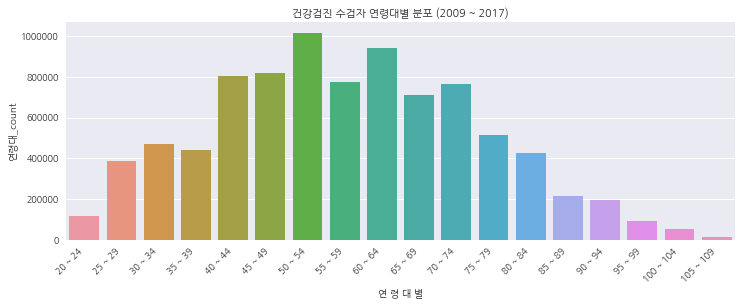

In [78]:
df_31=df.groupby(['연령대코드(5세단위)','연령대_CAT'])[[ '연령대_CAT']].count()
df_31.columns = ['연령대_count' ]
df_31 = df_31.reset_index()
df_31 = df_31.set_index('연령대_CAT')
df_31.head()

def Plot(df):

    plt.figure(figsize=(12,4))
#     fig, ax =plt.figure(figsize=(8,4))
    sns.set(font_scale=0.9)

#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

       # 한글깨짐 리눅스
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df.index, y=df['연령대_count'], data=df)
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('연 령 대 별')
    plt.title(f'건강검진 수검자 연령대별 분포 (2009 ~ 2017)')
    plt.savefig(f"./img/visual/age.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_31)

In [74]:
df_age = df.groupby(['기준년도','연령대_CAT'])[['연령대코드(5세단위)']].count()
df_age.columns=["연령대코드_count"]
df_age = df_age.reset_index()
df_age = df_age.set_index('기준년도')

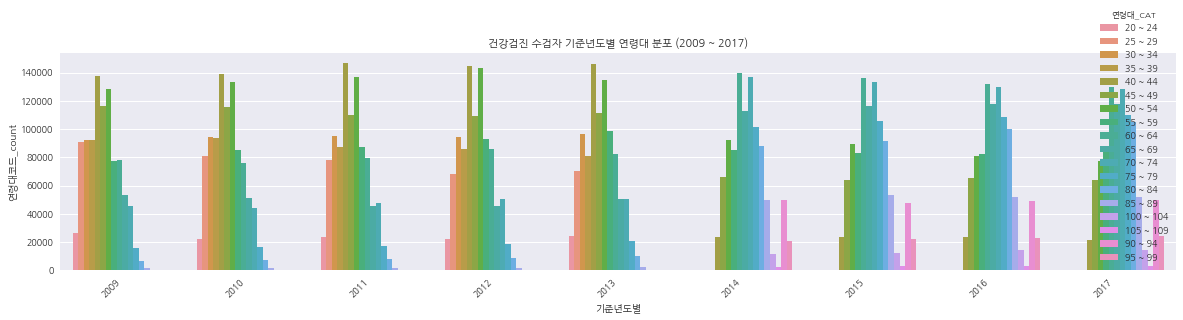

In [77]:
def Plot(df):

    plt.figure(figsize=(20,4))
#     fig, ax =plt.figure(figsize=(8,4))
    sns.set(font_scale=0.9)

#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

       # 한글깨짐 리눅스
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df.index, y=df['연령대코드_count'], data=df, hue="연령대_CAT")
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('기준년도별')
    plt.title(f'건강검진 수검자 기준년도별 연령대 분포 (2009 ~ 2017)')
    plt.savefig(f"./img/visual/age_year.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_age)

### 연령대 시각화

#### Plot 1 연령대별 수치형 feature 평균값(mean)

#### 연령대_CAT가 object라서 정렬되지 않아서, '연령대코드(5세단위)'활용

In [ ]:
# '연령대_CAT' object --> float  # error
# df['연령대_CAT'] = df['연령대_CAT'].astype('float64')

In [91]:
# df_1=df.groupby(['연령대코드(5세단위)', '연령대_CAT'], as_index=False).sum()
# df_1=df.groupby(['연령대코드(5세단위)']).sum()
# df_1=df.groupby(['연령대코드(5세단위)','연령대_CAT']).mean()
df_1=df.groupby(['연령대코드(5세단위)','연령대_CAT']).mean()[['BMI','신장(5Cm단위)','체중(5Kg단위)','허리둘레','시력(좌)', '시력(우)',
                                                   '수축기혈압', '이완기혈압', '식전혈당(공복혈당)','총콜레스테롤', '트리글리세라이드',
                                                   'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '혈청크레아티닌',
                                                   '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피']]
# print(df_1.head())
# df_1.index()  # MultiIndex' object is not callable
df_1.reset_index(level=['연령대코드(5세단위)'], inplace=True)
df_1.drop('연령대코드(5세단위)', axis=1, inplace=True)
df_1.head(5)

,BMI,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),수축기혈압,이완기혈압,식전혈당(공복혈당),총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피
연령대_CAT,,,,,,,,,,,,,,,,,,
20 ~ 24,21.481940,164.367789,58.390460,72.683444,1.037183,1.032235,113.985521,71.203506,87.310834,170.876609,83.053340,60.762168,94.145936,13.924509,0.882826,20.766592,17.558122,19.309359
25 ~ 29,22.304494,166.526390,62.329974,75.837536,1.064389,1.059229,116.359639,72.801814,88.720067,179.926129,102.086281,59.086042,101.146086,14.305990,0.910345,22.292897,22.132157,26.274896
30 ~ 34,23.318829,167.835952,66.113293,79.291031,1.096300,1.092649,118.562149,74.403258,91.389246,188.524091,126.147377,55.793339,108.356819,14.578402,0.931346,23.911479,26.763352,34.139653
35 ~ 39,23.628050,166.975433,66.235181,80.252102,1.125407,1.120915,119.847226,75.566076,93.955746,192.976308,138.121907,54.528559,111.796214,14.517855,0.939498,24.573145,27.516500,38.434400
40 ~ 44,23.387536,163.820464,63.084064,78.643363,1.070192,1.065446,118.798981,74.819734,94.893210,191.945223,124.701892,56.449647,111.277658,14.006112,0.885287,23.877085,24.314653,34.399600


In [92]:
# df_1.applymap(lambda x: round(x)) # 그대로
# df_1.applymap(lambda x: float(f'{x:.2f}')) # 그대로
# df_1.applymap(lambda x: f'{x:.2f}') # 그대로
# df_1.applymap(lambda x: {0:.2f}.format(x))

# f = lambda x: pd.Series([x.round]) # 그대로
# df_1.apply(f)

df_2=np.around(df_1.applymap(lambda x: x))
df_2.head(5)

,BMI,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),수축기혈압,이완기혈압,식전혈당(공복혈당),총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피
연령대_CAT,,,,,,,,,,,,,,,,,,
20 ~ 24,21.0,164.0,58.0,73.0,1.0,1.0,114.0,71.0,87.0,171.0,83.0,61.0,94.0,14.0,1.0,21.0,18.0,19.0
25 ~ 29,22.0,167.0,62.0,76.0,1.0,1.0,116.0,73.0,89.0,180.0,102.0,59.0,101.0,14.0,1.0,22.0,22.0,26.0
30 ~ 34,23.0,168.0,66.0,79.0,1.0,1.0,119.0,74.0,91.0,189.0,126.0,56.0,108.0,15.0,1.0,24.0,27.0,34.0
35 ~ 39,24.0,167.0,66.0,80.0,1.0,1.0,120.0,76.0,94.0,193.0,138.0,55.0,112.0,15.0,1.0,25.0,28.0,38.0
40 ~ 44,23.0,164.0,63.0,79.0,1.0,1.0,119.0,75.0,95.0,192.0,125.0,56.0,111.0,14.0,1.0,24.0,24.0,34.0


#### plot 연령대별 평균값

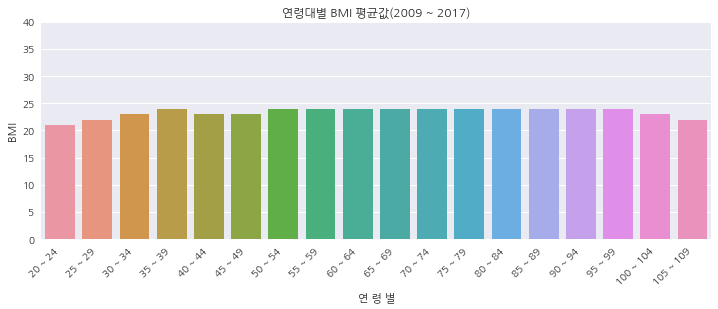

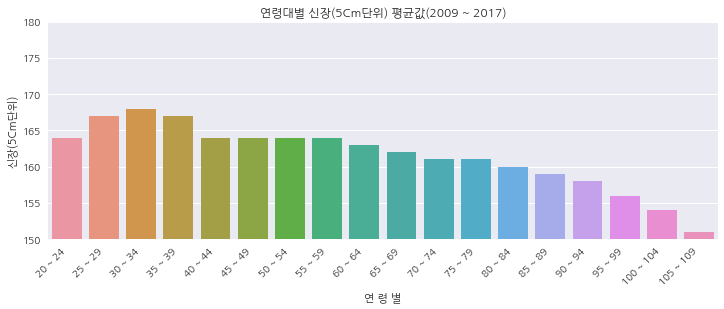

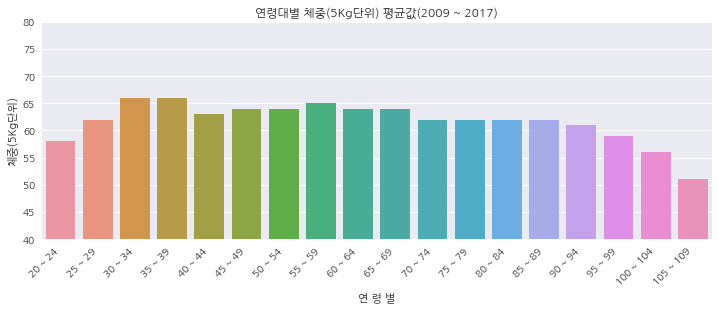

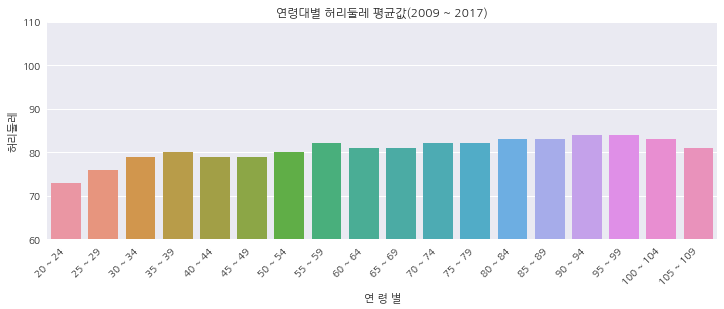

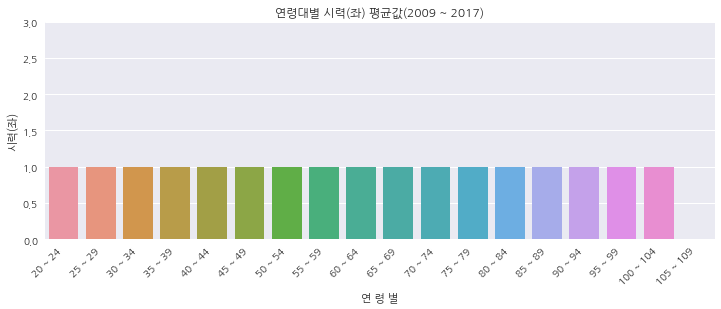

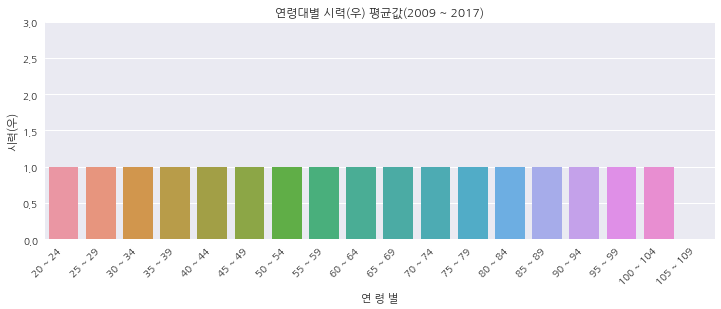

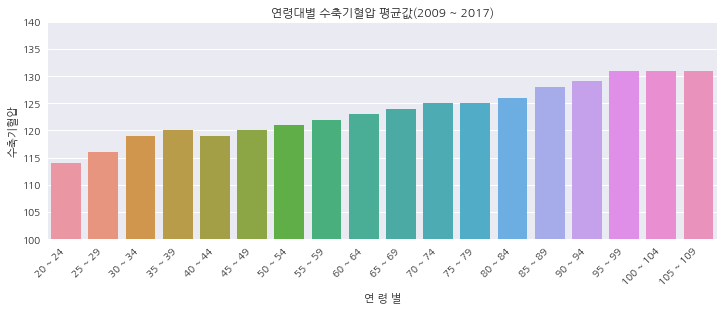

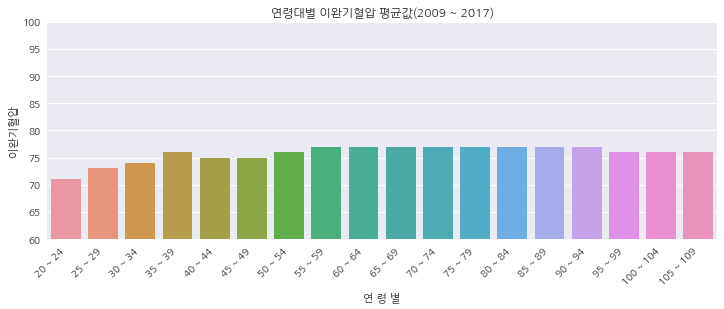

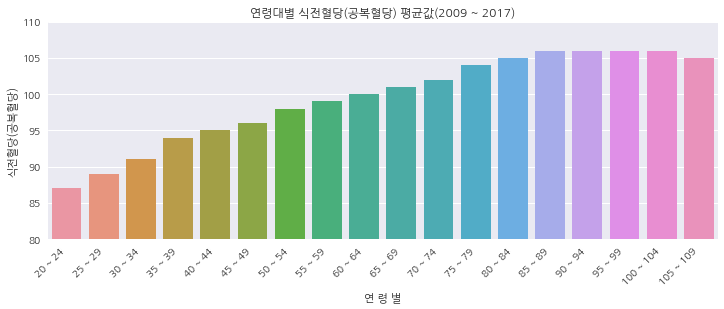

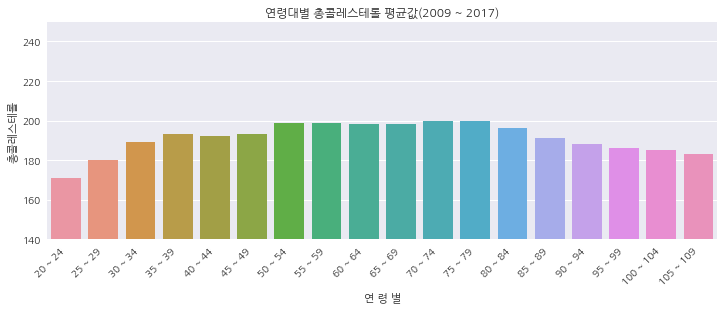

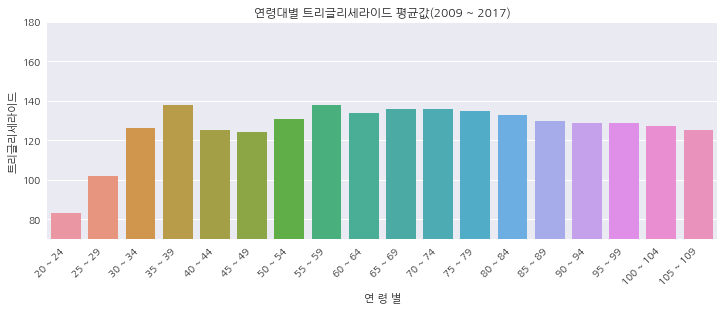

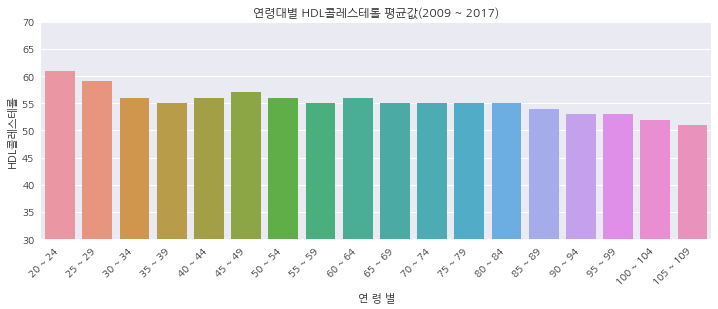

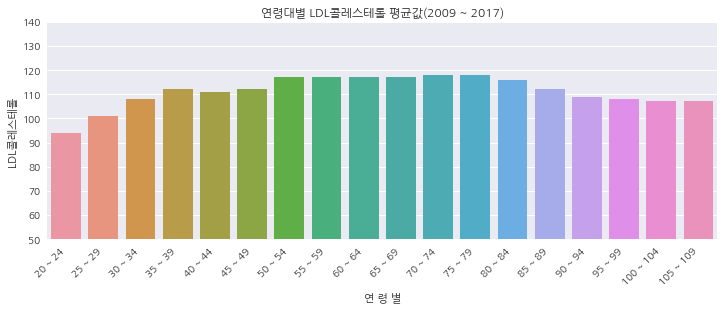

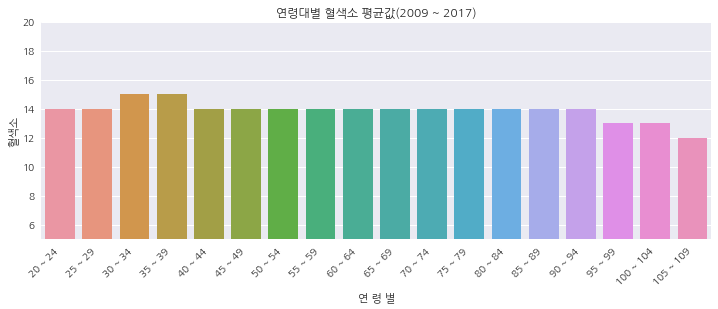

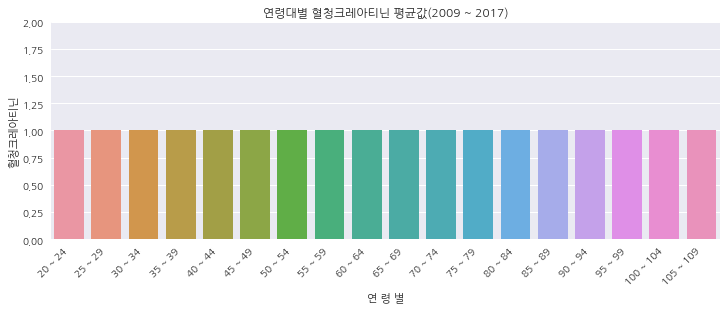

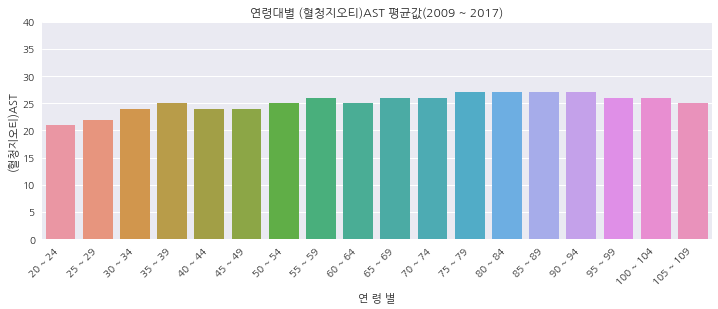

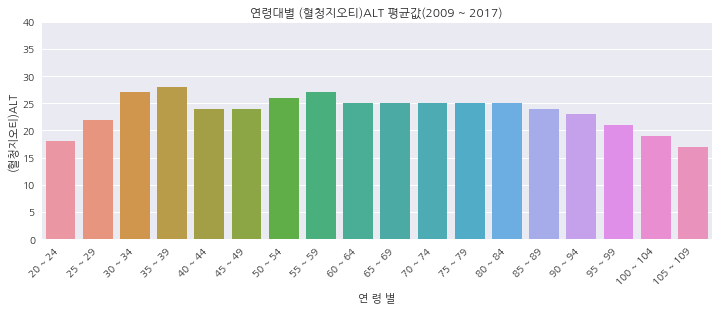

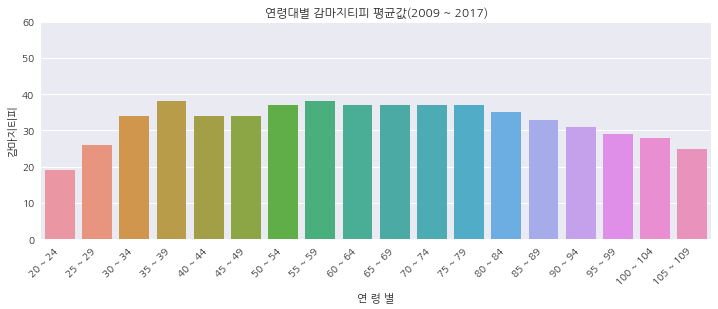

In [94]:
## ylim에 대해서 tuple로 value로 조정
temp_dict={'BMI': (0,40),
           '신장(5Cm단위)': (150,180),
           '체중(5Kg단위)': (40,80),
           '허리둘레' : (60, 110),
           '시력(좌)' : (0, 3),
           '시력(우)' : (0, 3),
           '수축기혈압' : (100,140),
           '이완기혈압' : (60,100),
           '식전혈당(공복혈당)' : (80,110),
           '총콜레스테롤' : (140,250),
           '트리글리세라이드' : (70,180),
           'HDL콜레스테롤' : (30,70),
           'LDL콜레스테롤' : (50,140),
           '혈색소' : (5, 20),
           '혈청크레아티닌' : (0, 2),
           '(혈청지오티)AST' : (0, 40),
           '(혈청지오티)ALT' : (0, 40),
           '감마지티피' : (0, 60)
          }
# temp_lst=['BMI', '신장(5Cm단위)', '체중(5Kg단위)','허리둘레','시력(좌)','시력(우)','청력(좌)', '청력(우)','수축기혈압','이완기혈압','식전혈당(공복혈당)',
#            '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤','LDL콜레스테롤', '혈색소','혈청크레아티닌','(혈청지오티)AST', '(혈청지오티)ALT',
#            '감마지티피' ]
def Plot(df):
#     for column in temp_lst:
    for column, tup in temp_dict.items():
        plt.figure(figsize=(12,4))
    #     fig, ax =plt.figure(figsize=(8,4))
        sns.set(font_scale=1.0)
        # 한글깨짐 윈도우
#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf
        
        # 한글깨짐 리눅스
        mpl.rcParams['font.family'] = 'NanumGothic'
        mpl.rc('axes', unicode_minus=False)

        ax = sns.barplot(x=df.index, y=column, data=df)
        start, end = tup
        ax.set_ylim(start, end)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
        ax.set_xlabel('연 령 별')
        plt.title(f'연령대별 {column} 평균값(2009 ~ 2017)')
        plt.savefig(f"./img/visual/age_{column}_mean.png" ,dpi=150, bbox_inches='tight')
        plt.show()
    #     plt.close()
Plot(df_2)

#### Plot 2 연령별 성별 수치형 feature 평균값

In [ ]:
df.columns

In [33]:
# df_3=df.groupby(['연령대코드(5세단위)','연령대_CAT', '성별_CAT']).mean()[['BMI','신장(5Cm단위)','체중(5Kg단위)','허리둘레','시력(좌)', '시력(우)',
#                                                    '수축기혈압', '이완기혈압', '식전혈당(공복혈당)','총콜레스테롤', '트리글리세라이드',
#                                                    'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '혈청크레아티닌',
#                                                    '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피',]]
df_3=df.groupby(['연령대코드(5세단위)','연령대_CAT', '성별_CAT']).mean()
df_4=np.around(df_3.applymap(lambda x: x))
df_4.reset_index(level=['연령대코드(5세단위)', '성별_CAT'], inplace=True)
df_4.drop('연령대코드(5세단위)', axis=1, inplace=True)

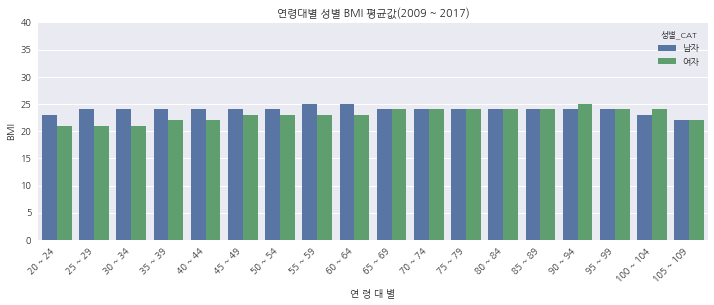

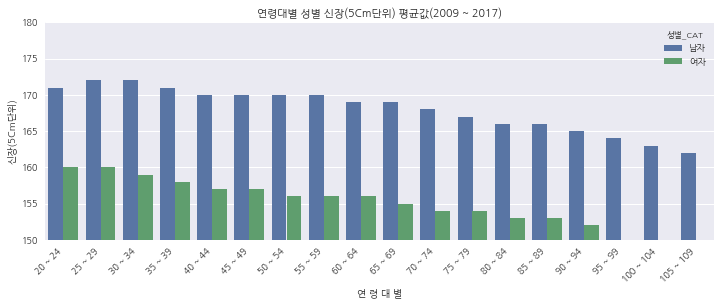

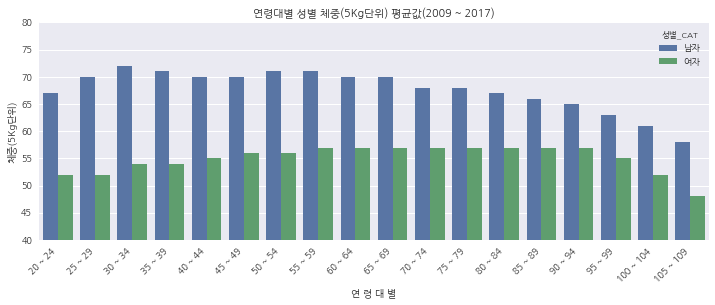

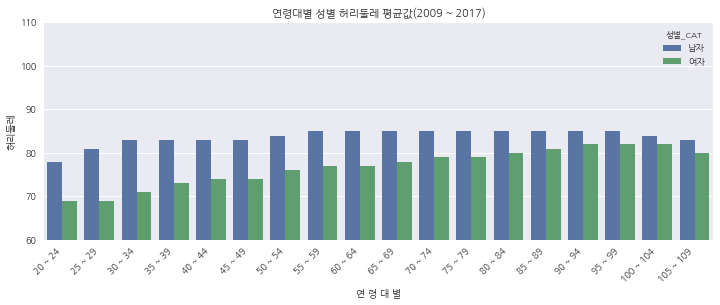

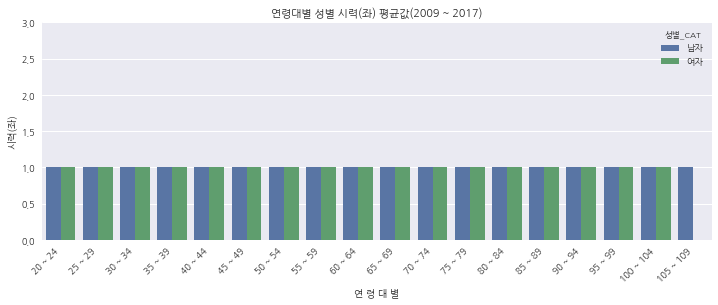

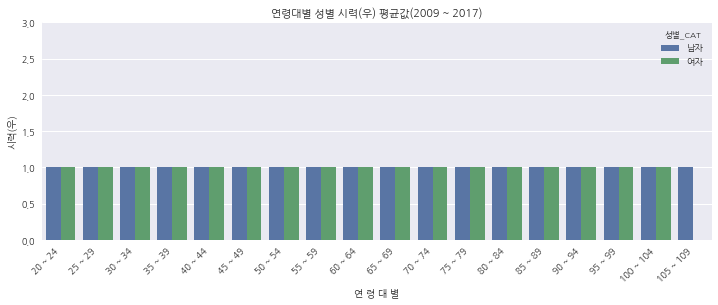

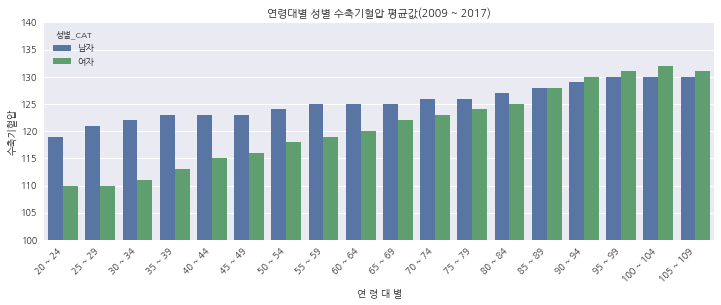

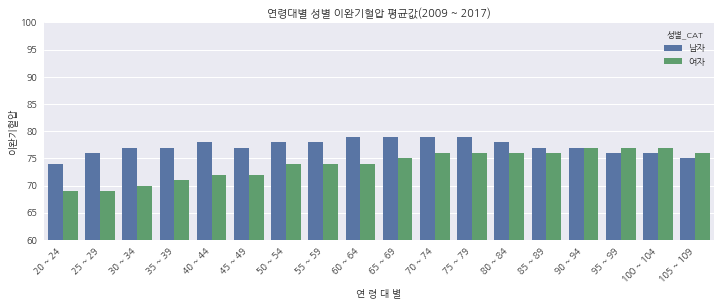

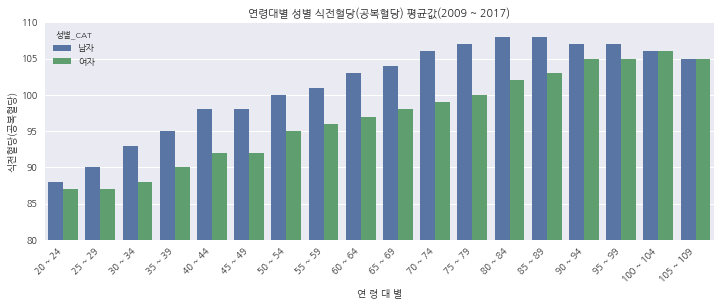

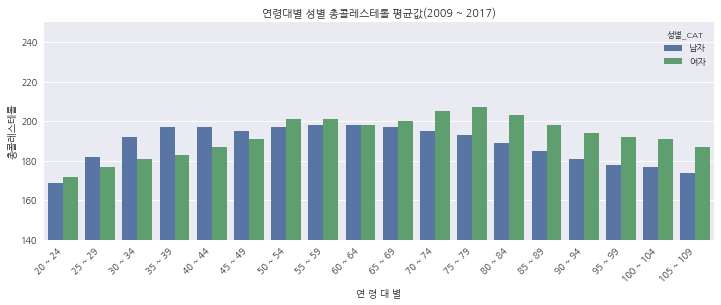

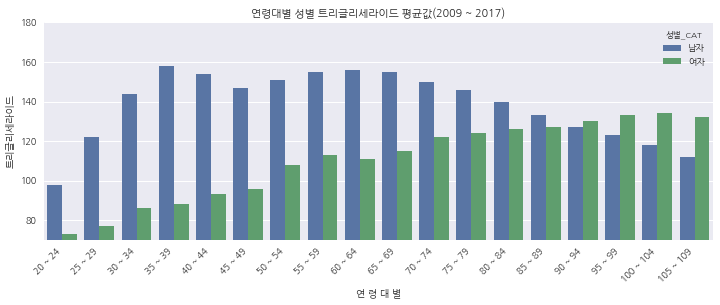

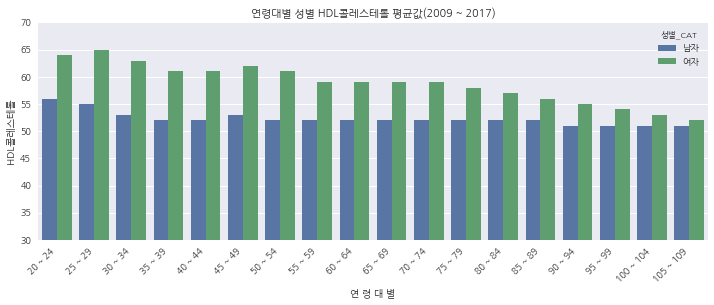

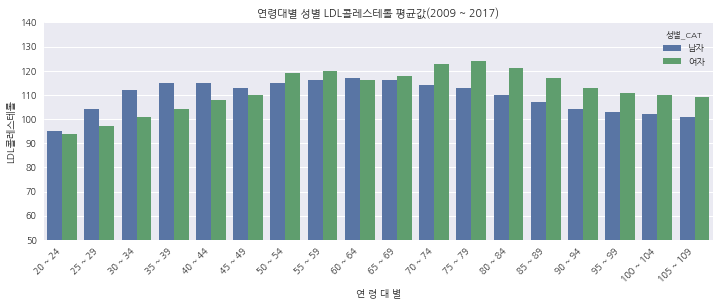

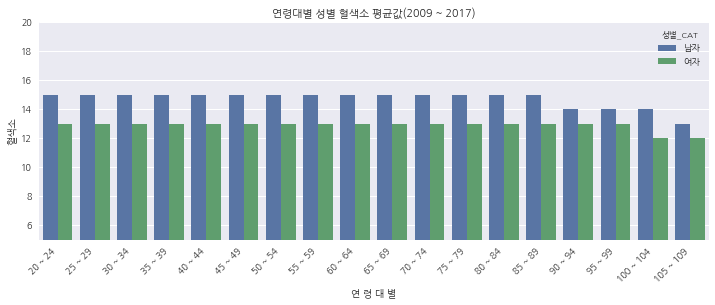

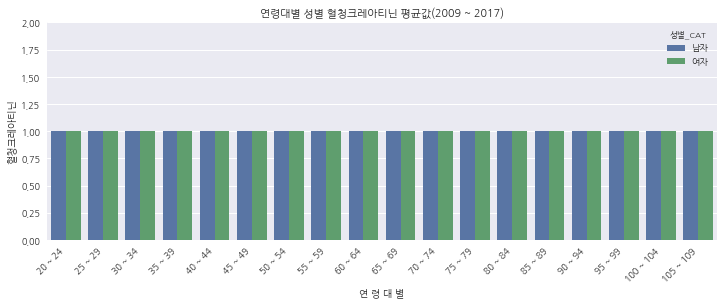

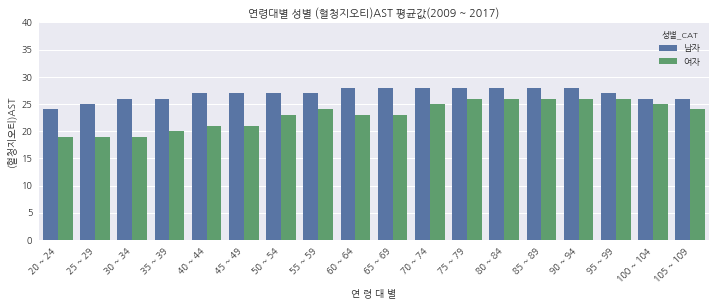

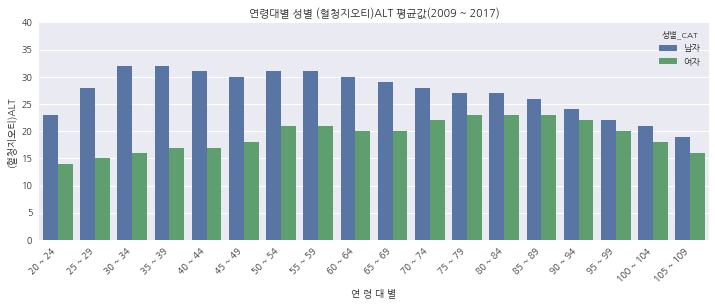

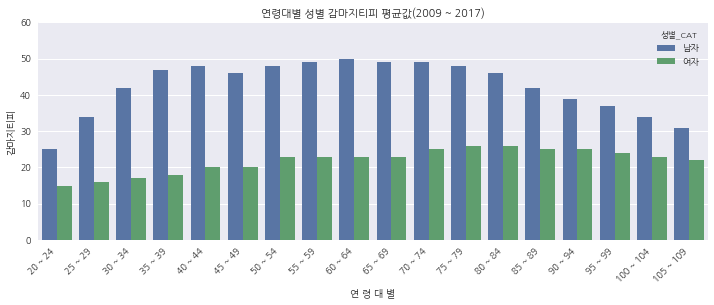

In [95]:
def Plot(df):
#     for column in temp_lst:
    for column, tup in temp_dict.items():
        plt.figure(figsize=(12,4))
    #     fig, ax =plt.figure(figsize=(8,4))
        sns.set(font_scale=0.9)
        
#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

           # 한글깨짐 리눅스
        mpl.rcParams['font.family'] = 'NanumGothic'
        mpl.rc('axes', unicode_minus=False)
        ax = sns.barplot(x=df.index, y=column, data=df, hue='성별_CAT')
        start, end = tup
        ax.set_ylim(start, end)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
        ax.set_xlabel('연 령 대 별')
        plt.title(f'연령대별 성별 {column} 평균값(2009 ~ 2017)')
        plt.savefig(f"./img/visual/age_sex_{column}_mean.png",dpi=150, bbox_inches='tight')
        plt.show()
    #     plt.close()
Plot(df_4)

In [ ]:
#### 

In [39]:
df_33=df.groupby(['연령대코드(5세단위)','연령대_CAT', '성별_CAT','흡연상태_CAT'])[[ '성별코드', '흡연상태']].count()
df_33.columns = ['성별코드_count','흡연상태_count' ]
df_33 = df_33.reset_index()
df_33 = df_33.set_index('연령대_CAT')
df_33.head()

def Plot(df):

    plt.figure(figsize=(12,4))
#     fig, ax =plt.figure(figsize=(8,4))
    sns.set(font_scale=0.9)

#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

       # 한글깨짐 리눅스
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df.index, y=df['흡연상태_count'], data=df, hue='흡연상태_CAT')
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('연 령 대 별')
    plt.title(f'연령대별 흡연상태 (2009 ~ 2017)')
    plt.savefig(f"./img/visual/age_taboco_.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_33)

,연령대코드(5세단위),성별_CAT,흡연상태_CAT,성별코드_count,흡연상태_count
연령대_CAT,,,,,
20 ~ 24,1,남자,이전에 피웠으나 끊었다,2874,2874
20 ~ 24,1,남자,피우지 않는다,20312,20312
20 ~ 24,1,남자,현재도 피우고 있다,25457,25457
20 ~ 24,1,여자,이전에 피웠으나 끊었다,2434,2434
20 ~ 24,1,여자,피우지 않는다,62056,62056


In [44]:
df_34=df.groupby(['연령대코드(5세단위)','연령대_CAT', '음주여부_count'])[[ '음주여부']].count()
df_34.columns = ['음주여부_count' ]
df_34 = df_34.reset_index()
df_34 = df_34.set_index('연령대_CAT')
df_34.head()

def Plot(df):

    plt.figure(figsize=(12,4))
#     fig, ax =plt.figure(figsize=(8,4))
    sns.set(font_scale=0.9)

#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

       # 한글깨짐 리눅스
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df.index, y=df['음주여부_count'], data=df, hue='음주여부_CAT')
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('연 령 대 별')
    plt.title(f'연령대별 음주여부 (2009 ~ 2017)')
    plt.savefig(f"./img/visual/age_alchol_.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_34)

,연령대코드(5세단위),음주여부_CAT,음주여부_count
연령대_CAT,,,
20 ~ 24,1,마시지 않은다,45758
20 ~ 24,1,마신다,72897
25 ~ 29,2,마시지 않은다,137917
25 ~ 29,2,마신다,250244
30 ~ 34,3,마시지 않은다,170539


In [47]:
df_35=df.groupby(['연령대코드(5세단위)','연령대_CAT', '구강검진수검_CAT'])[[ '구강검진수검여부']].count()
df_35.columns = ['구강검진수검여부_count' ]
df_35 = df_35.reset_index()
df_35 = df_35.set_index('연령대_CAT')
# df_35.head()

def Plot(df):

    plt.figure(figsize=(12,4))
#     fig, ax =plt.figure(figsize=(8,4))
    sns.set(font_scale=0.9)

#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

       # 한글깨짐 리눅스
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df.index, y=df['구강검진수검여부_count'], data=df, hue='구강검진수검_CAT')
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('연 령 대 별')
    plt.title(f'연령대별 구강검진수검여부 (2009 ~ 2017)')
    plt.savefig(f"./img/visual/age_gukang_.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_35)

In [37]:
df.columns

Index(['기준년도', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레',
       '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
       '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부', '구강검진수검여부',
       'target', 'target_CAT', '시도코드_CAT', '연령대_CAT', '성별_CAT', '흡연상태_CAT',
       '음주여부_CAT', '구강검진수검_CAT', '청력(좌)_CAT', '청력(우)_CAT', 'W', 'H', 'BMI',
       'BMI_CAT'],
      dtype='object')

## 연도별

In [ ]:
df.columns

In [ ]:
df['기준년도'].value_counts()

In [97]:
df_5=df.groupby(['기준년도', '성별_CAT']).mean()[['BMI','신장(5Cm단위)','체중(5Kg단위)','허리둘레','시력(좌)', '시력(우)',
                                       '수축기혈압', '이완기혈압', '식전혈당(공복혈당)','총콜레스테롤', '트리글리세라이드',
                                        'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '혈청크레아티닌',
                                        '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피',]]
df_5.reset_index(level=['성별_CAT'], inplace=True)
df_6=np.around(df_5.applymap(lambda x: x))

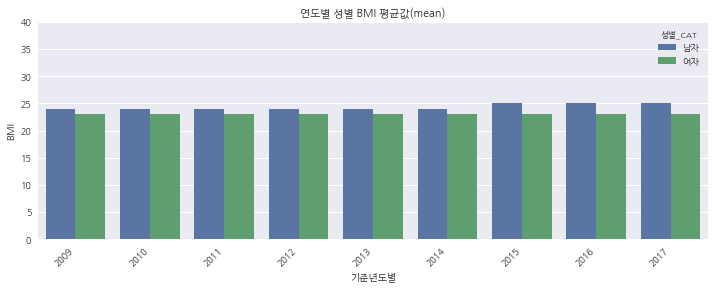

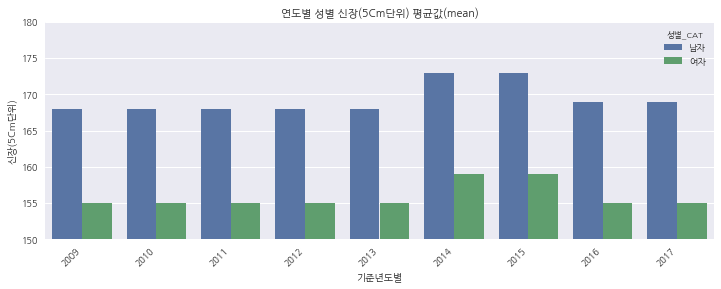

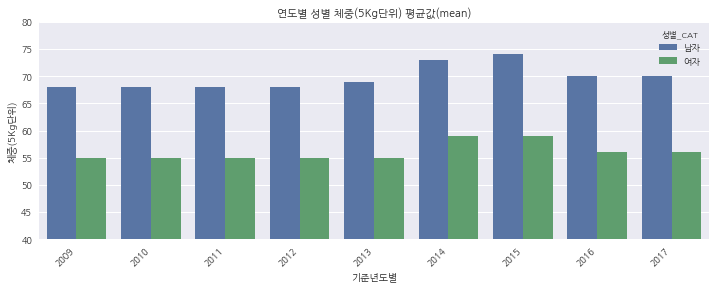

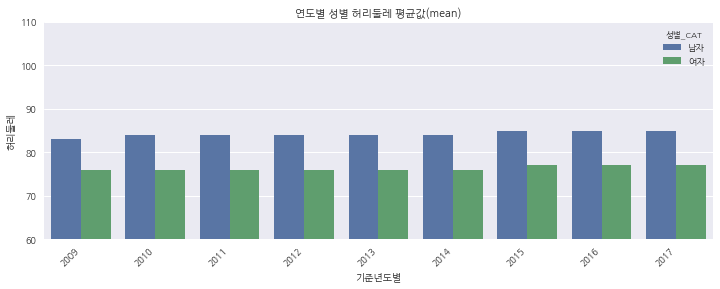

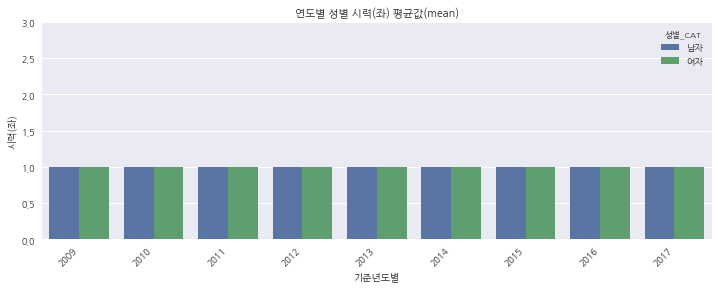

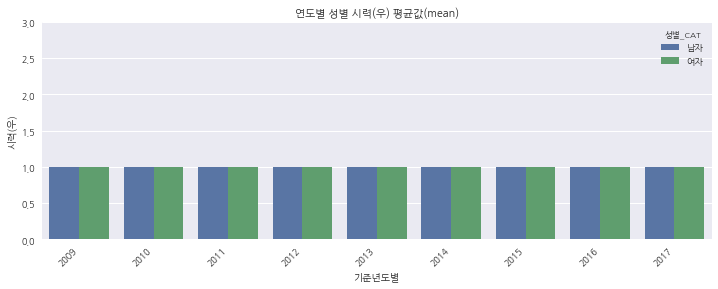

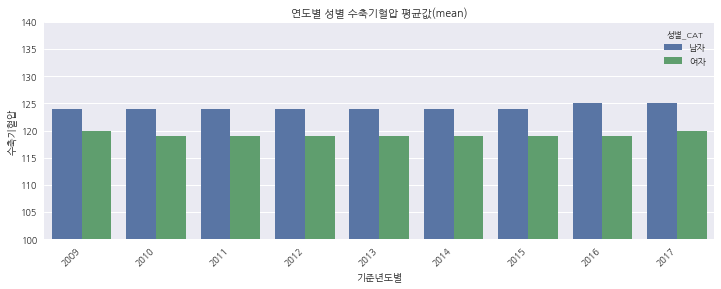

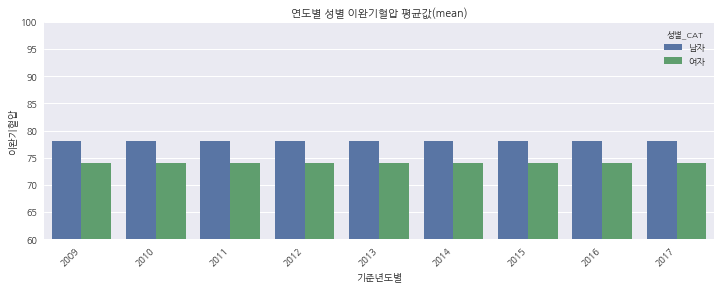

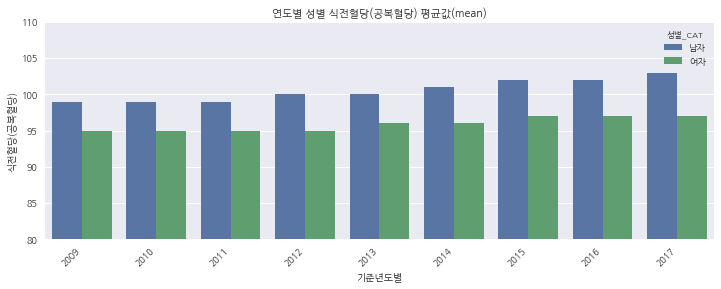

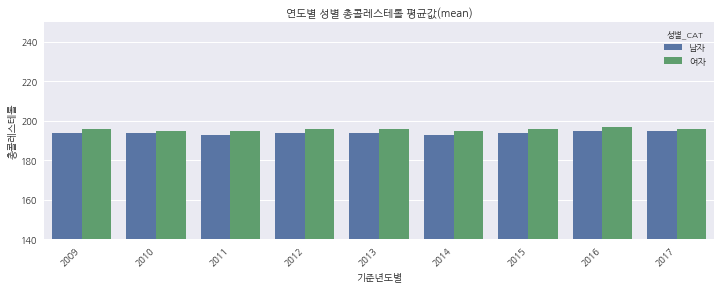

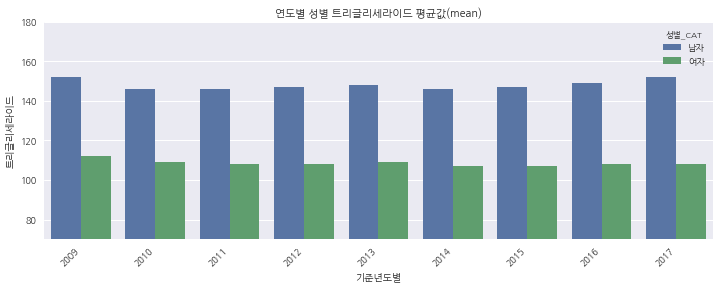

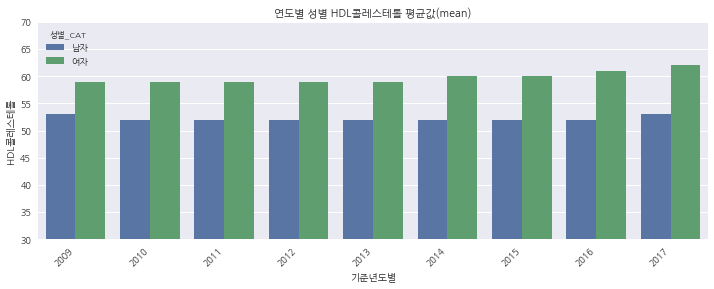

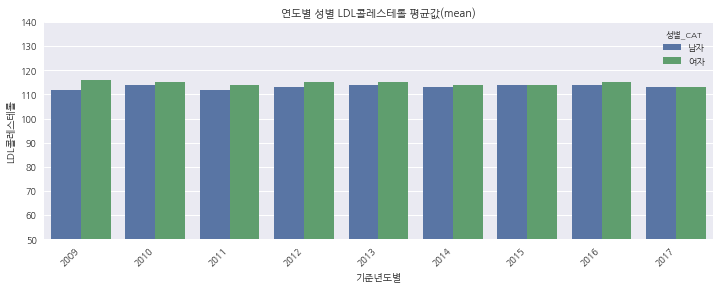

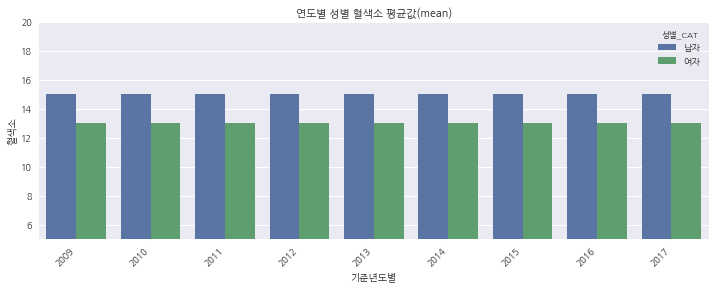

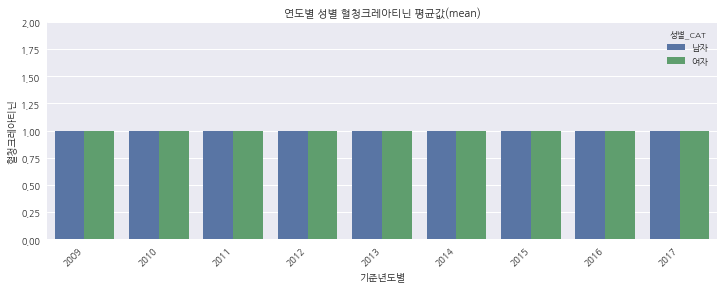

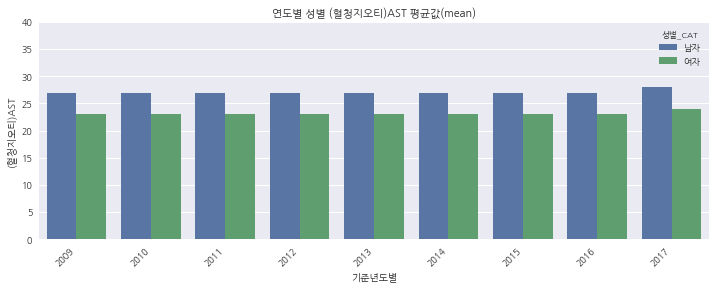

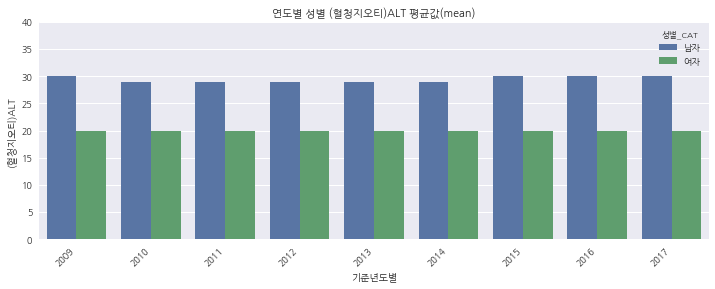

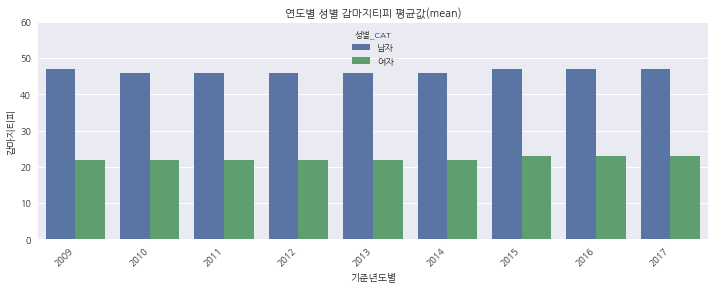

In [98]:
def Plot(df):
#     for column in temp_lst:
    for column, tup in temp_dict.items():
        plt.figure(figsize=(12,4))
    #     fig, ax =plt.figure(figsize=(8,4))
        sns.set(font_scale=0.9)
        
#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf
        
           # 한글깨짐 리눅스
        mpl.rcParams['font.family'] = 'NanumGothic'
        mpl.rc('axes', unicode_minus=False)

        ax = sns.barplot(x=df.index, y=column, data=df, hue='성별_CAT')
        start, end = tup
        ax.set_ylim(start, end)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
        ax.set_xlabel('기준년도별')
        plt.title(f'연도별 성별 {column} 평균값(mean)')
        plt.savefig(f"./img/visual/year_sex_{column}_mean.png",dpi=150, bbox_inches='tight')
        plt.show()
    #     plt.close()
Plot(df_6)

In [ ]:
#### 

In [80]:
df.columns

Index(['기준년도', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레',
       '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
       '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부', '구강검진수검여부',
       'target', 'target_CAT', '시도코드_CAT', '연령대_CAT', '성별_CAT', '흡연상태_CAT',
       '음주여부_CAT', '구강검진수검_CAT', '청력(좌)_CAT', '청력(우)_CAT', 'W', 'H', 'BMI',
       'BMI_CAT'],
      dtype='object')

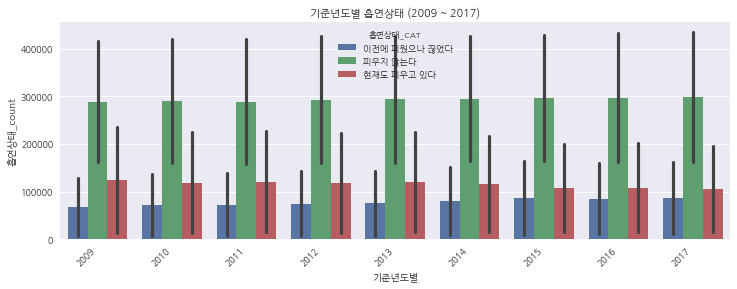

In [81]:
df_43=df.groupby(['기준년도', '성별_CAT','흡연상태_CAT'])[[ '성별코드', '흡연상태']].count()
df_43.columns = ['성별코드_count','흡연상태_count' ]
df_43 = df_43.reset_index()
df_43 = df_43.set_index('기준년도')

def Plot(df):

    plt.figure(figsize=(12,4))
#     fig, ax =plt.figure(figsize=(8,4))
    sns.set(font_scale=0.9)

#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

       # 한글깨짐 리눅스
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df.index, y=df['흡연상태_count'], data=df, hue='흡연상태_CAT')
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('기준년도별')
    plt.title(f'기준년도별 흡연상태 (2009 ~ 2017)')
    plt.savefig(f"./img/visual/year_taboco_.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_43)

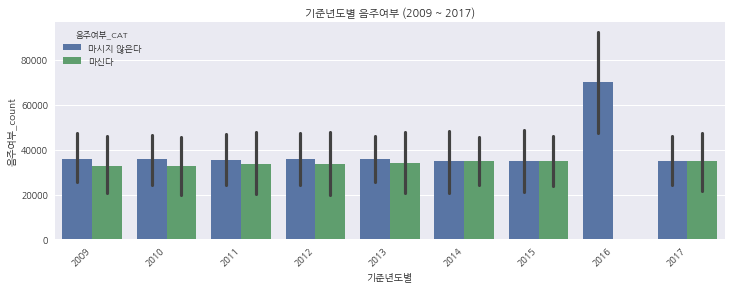

In [84]:
df_44=df.groupby(['기준년도','연령대_CAT', '음주여부_CAT'])[[ '음주여부']].count()
df_44.columns = ['음주여부_count' ]
df_44 = df_44.reset_index()
df_44 = df_44.set_index('기준년도')
df_44.head()

def Plot(df):

    plt.figure(figsize=(12,4))
#     fig, ax =plt.figure(figsize=(8,4))
    sns.set(font_scale=0.9)

#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

       # 한글깨짐 리눅스
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df.index, y=df['음주여부_count'], data=df, hue='음주여부_CAT')
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('기준년도별')
    plt.title(f'기준년도별 음주여부 (2009 ~ 2017)')
    plt.savefig(f"./img/visual/year_alchol_.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_44)

In [ ]:
### 2016년도 100만건 자료에도 음주여부 0으로 되어 있음

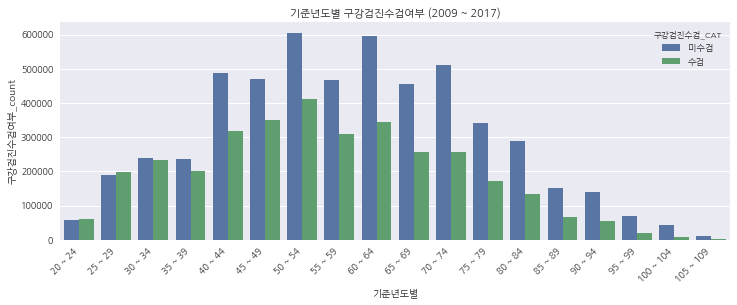

In [85]:
df_45=df.groupby(['기준년도','구강검진수검_CAT'])[[ '구강검진수검여부']].count()
df_45.columns = ['구강검진수검여부_count' ]
df_45 = df_45.reset_index()
df_45 = df_45.set_index('기준년도')
# df_35.head()

def Plot(df):

    plt.figure(figsize=(12,4))
#     fig, ax =plt.figure(figsize=(8,4))
    sns.set(font_scale=0.9)

#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

       # 한글깨짐 리눅스
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df.index, y=df['구강검진수검여부_count'], data=df, hue='구강검진수검_CAT')
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('기준년도별')
    plt.title(f'기준년도별 구강검진수검여부 (2009 ~ 2017)')
    plt.savefig(f"./img/visual/year_gukang_.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_35)

### 시도별

In [99]:
df_9=df.groupby(['시도코드','시도코드_CAT', '성별_CAT']).mean()[['BMI','신장(5Cm단위)','체중(5Kg단위)','허리둘레','시력(좌)', '시력(우)',
                                       '수축기혈압', '이완기혈압', '식전혈당(공복혈당)','총콜레스테롤', '트리글리세라이드',
                                        'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '혈청크레아티닌',
                                        '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피',]]
# df_9=df.groupby(['시도코드','시도코드_CAT', '성별_CAT']).mean()
df_10=np.around(df_9.applymap(lambda x: x))
df_10.reset_index(level=['시도코드', '성별_CAT'], inplace=True)
df_10.drop('시도코드', axis=1, inplace=True)

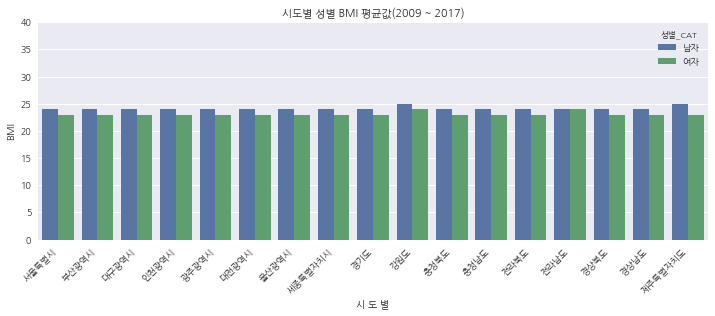

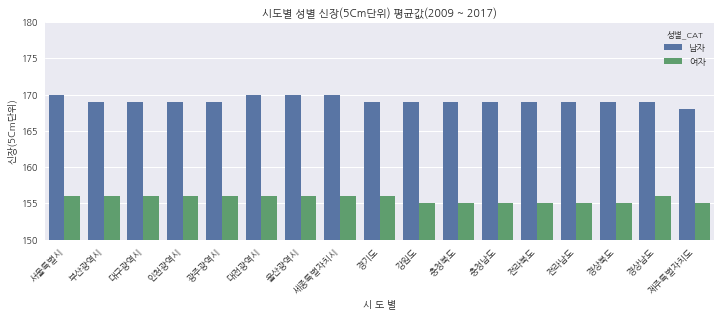

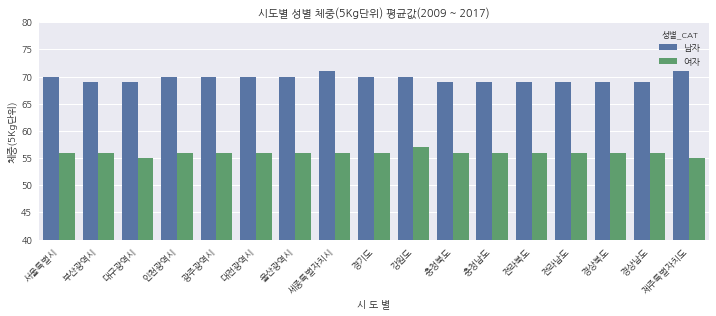

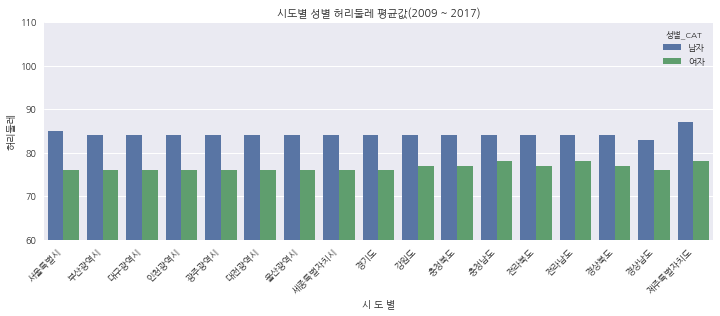

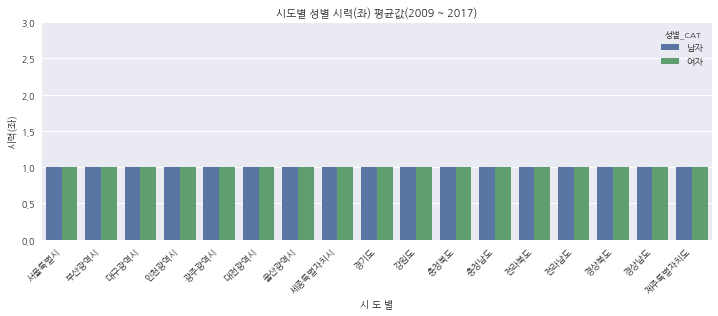

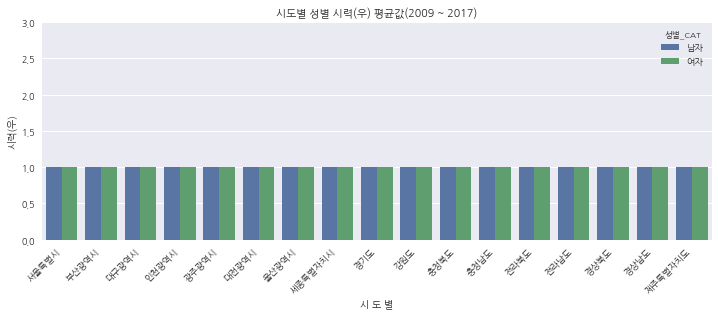

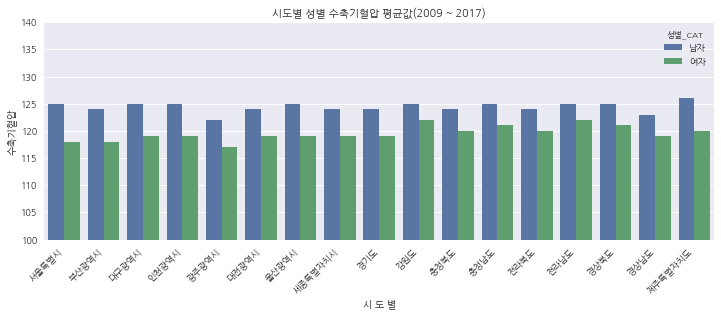

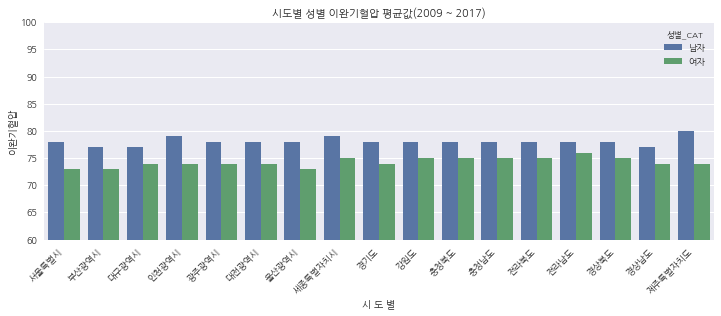

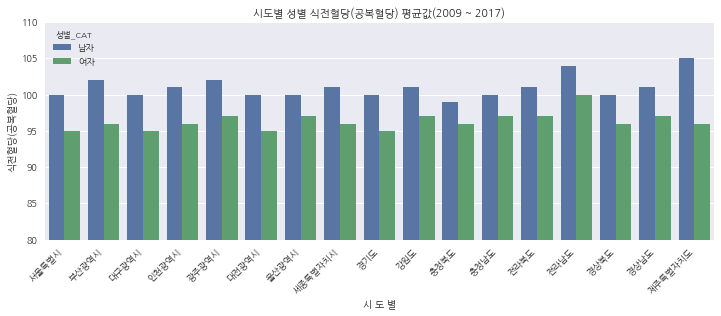

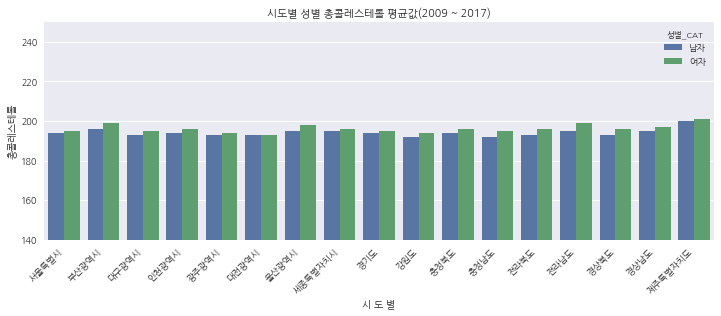

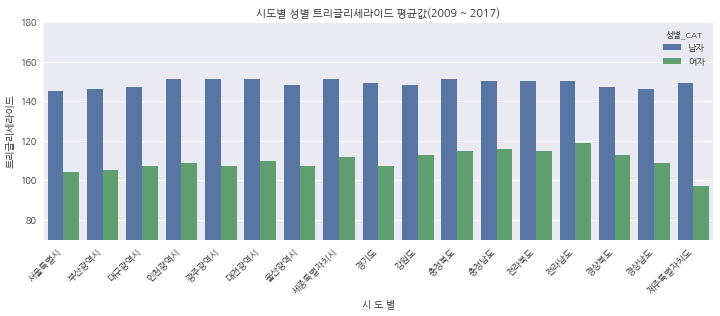

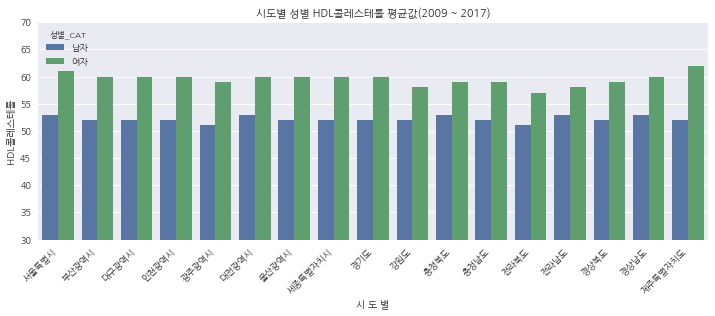

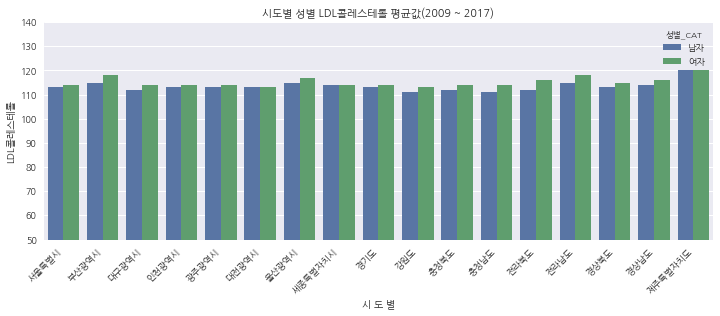

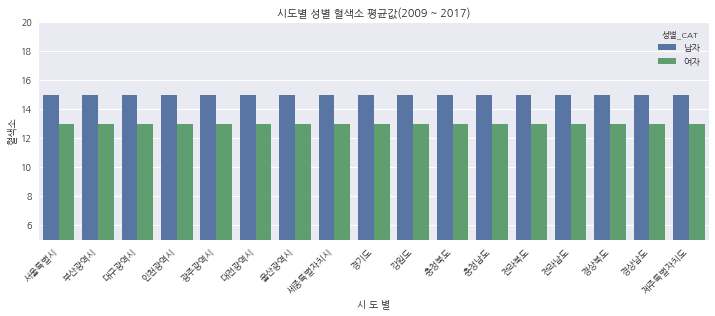

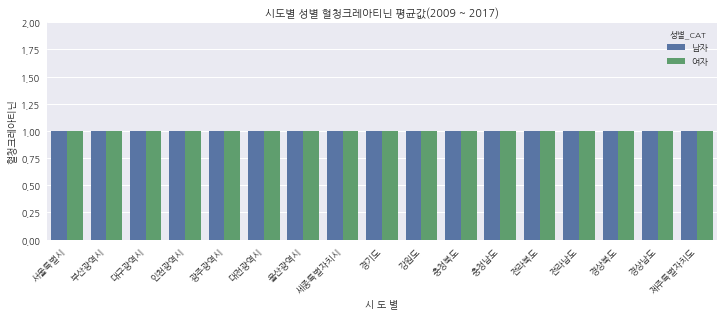

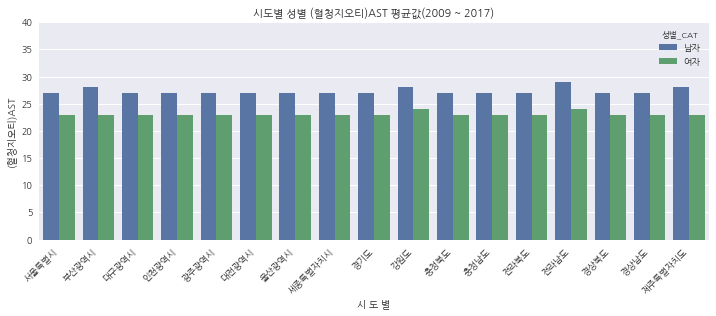

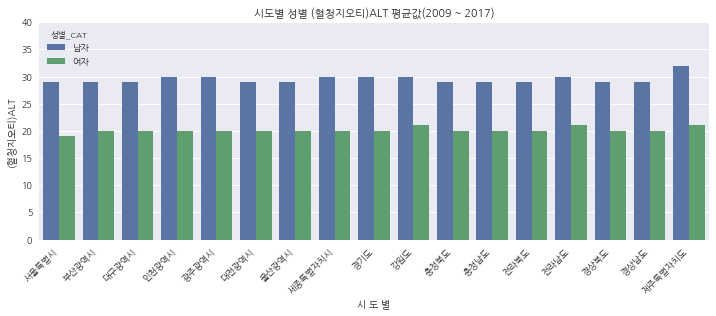

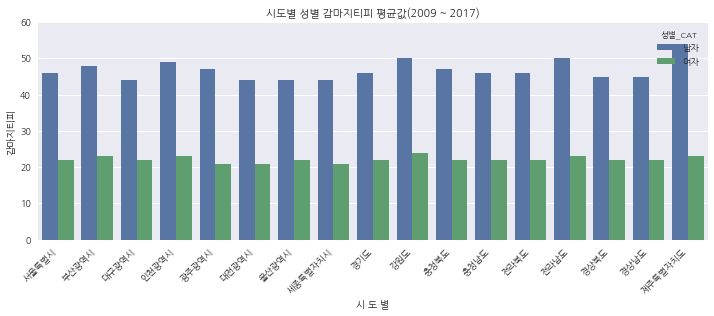

In [100]:
def Plot(df):
#     for column in temp_lst:
    for column, tup in temp_dict.items():
        plt.figure(figsize=(12,4))
    #     fig, ax =plt.figure(figsize=(8,4))
        sns.set(font_scale=0.9)
        
#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf
        
           # 한글깨짐 리눅스
        mpl.rcParams['font.family'] = 'NanumGothic'
        mpl.rc('axes', unicode_minus=False)

        ax = sns.barplot(x=df.index, y=column, data=df, hue='성별_CAT')
        start, end = tup
        ax.set_ylim(start, end)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
        ax.set_xlabel('시 도 별')
        plt.title(f'시도별 성별 {column} 평균값(2009 ~ 2017)')
        plt.savefig(f"./img/visual/sido_sex_{column}_mean.png", dpi=150, bbox_inches='tight')
#         fig.savefig(out_fname,dpi=200,facecolor=fig.get_facecolor(),transparent=True,bbox_inches='tight')
        plt.show()
    #     plt.close()
Plot(df_10)

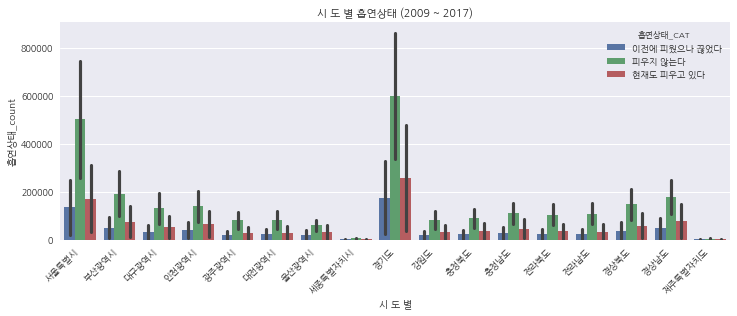

In [101]:
df_53=df.groupby(['시도코드','시도코드_CAT', '성별_CAT','흡연상태_CAT'])[[ '성별코드', '흡연상태']].count()
df_53.columns = ['성별코드_count','흡연상태_count' ]
df_53 = df_53.reset_index()
df_53 = df_53.set_index('시도코드_CAT')

def Plot(df):

    plt.figure(figsize=(12,4))
#     fig, ax =plt.figure(figsize=(8,4))
    sns.set(font_scale=0.9)

#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

       # 한글깨짐 리눅스
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df.index, y=df['흡연상태_count'], data=df, hue='흡연상태_CAT')
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('시 도 별')
    plt.title(f'시 도 별 흡연상태 (2009 ~ 2017)')
    plt.savefig(f"./img/visual/sido_taboco_.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_53)

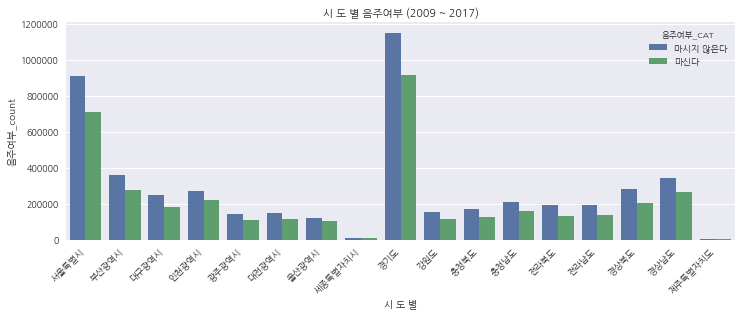

In [103]:
df_44=df.groupby(['시도코드','시도코드_CAT', '음주여부_CAT'])[[ '음주여부']].count()
df_44.columns = ['음주여부_count' ]
df_44 = df_44.reset_index()
df_44 = df_44.set_index('시도코드_CAT')
df_44.head()

def Plot(df):

    plt.figure(figsize=(12,4))
#     fig, ax =plt.figure(figsize=(8,4))
    sns.set(font_scale=0.9)

#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

       # 한글깨짐 리눅스
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df.index, y=df['음주여부_count'], data=df, hue='음주여부_CAT')
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('시 도 별')
    plt.title(f'시 도 별 음주여부 (2009 ~ 2017)')
    plt.savefig(f"./img/visual/sido_alchol_.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_44)

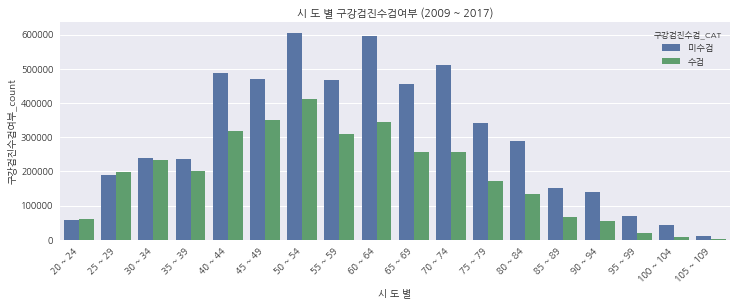

In [104]:
df_45=df.groupby(['시도코드','시도코드_CAT','구강검진수검_CAT'])[[ '구강검진수검여부']].count()
df_45.columns = ['구강검진수검여부_count' ]
df_45 = df_45.reset_index()
df_45 = df_45.set_index('시도코드_CAT')
# df_35.head()

def Plot(df):

    plt.figure(figsize=(12,4))
#     fig, ax =plt.figure(figsize=(8,4))
    sns.set(font_scale=0.9)

#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
#         mpl.rc('font', family=font_name) # ahronbd.ttf

       # 한글깨짐 리눅스
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    ax = sns.barplot(x=df.index, y=df['구강검진수검여부_count'], data=df, hue='구강검진수검_CAT')
#         start, end = tup
#         ax.set_ylim(start, end)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
    ax.set_xlabel('시 도 별')
    plt.title(f'시 도 별 구강검진수검여부 (2009 ~ 2017)')
    plt.savefig(f"./img/visual/sido_gukang_.png",dpi=150, bbox_inches='tight')
    plt.show()
    #     plt.close()
Plot(df_35)

###  당뇨 

In [ ]:
df.columns

In [105]:
df_11 = df.groupby(['연령대코드(5세단위)','연령대_CAT','target', 'target_CAT'])[['target']].count()
df_11.columns = ['target_count']
df_11 = df_11.reset_index()
# df_11['target_count'].sort_values(ascending=True)
df_11 = df_11.set_index('연령대_CAT')

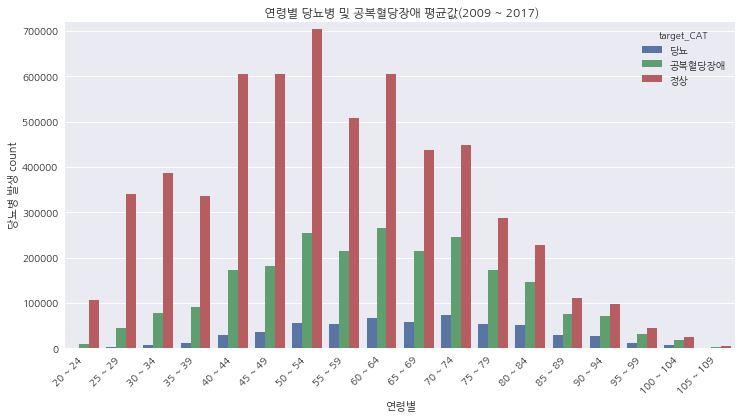

In [119]:
temp_dict={'target_count': (650,720000)}
def Plot(df):
    for column, tup in temp_dict.items():
        plt.figure(figsize=(12,6))
    #     fig, ax =plt.figure(figsize=(8,4))
        sns.set(font_scale=1.0)
        
#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() 
#         mpl.rc('font', family=font_name) # ahronbd.ttf
        
           # 한글깨짐 리눅스
        mpl.rcParams['font.family'] = 'NanumGothic'
        mpl.rc('axes', unicode_minus=False)

        ax = sns.barplot(x=df.index, y=column, data=df, hue='target_CAT')
        start, end = tup
        ax.set_ylim(start, end)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
        ax.set_xlabel('연령별')
        ax.set_ylabel('당뇨병 발생 count')
        plt.title(f' 연령별 당뇨병 및 공복혈당장애 평균값(2009 ~ 2017)')
        plt.savefig(f"./img/visual/diabete_age.png", dpi=100, bbox_inches='tight')
#         fig.savefig(out_fname,dpi=200,facecolor=fig.get_facecolor(),transparent=True,bbox_inches='tight')
        plt.show()
    #     plt.close()
Plot(df_11)

In [107]:
df_13 = df.groupby(['기준년도', 'target', 'target_CAT'])[['target']].count()
df_13.columns = ['target_count']
df_13 = df_13.reset_index()
# df_11['target_count'].sort_values(ascending=True)
df_13 = df_13.set_index('기준년도')
df_13.head()

,target,target_CAT,target_count
기준년도,,,
2009,1,당뇨,57737
2009,2,공복혈당장애,234057
2009,3,정상,671235
2010,1,당뇨,57418
2010,2,공복혈당장애,230344


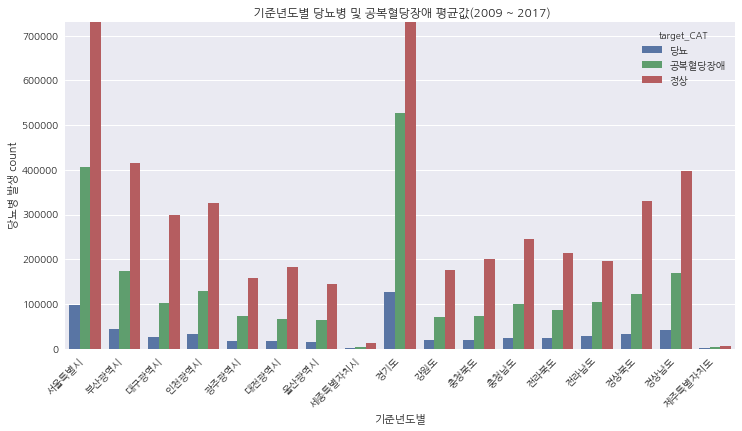

In [120]:
temp_dict={'target_count': (650,730000)}
def Plot(df):
    for column, tup in temp_dict.items():
        plt.figure(figsize=(12,6))
    #     fig, ax =plt.figure(figsize=(8,4))
        sns.set(font_scale=1.0)
        
#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() 
#         mpl.rc('font', family=font_name) # ahronbd.ttf
        
           # 한글깨짐 리눅스
        mpl.rcParams['font.family'] = 'NanumGothic'
        mpl.rc('axes', unicode_minus=False)

        ax = sns.barplot(x=df.index, y=column, data=df, hue='target_CAT')
        start, end = tup
        ax.set_ylim(start, end)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
        ax.set_xlabel('기준년도별')
        ax.set_ylabel('당뇨병 발생 count')
        plt.title(f' 기준년도별 당뇨병 및 공복혈당장애 평균값(2009 ~ 2017)')
        plt.savefig(f"./img/visual/diabete_year.png", dpi=100, bbox_inches='tight')
#         fig.savefig(out_fname,dpi=200,facecolor=fig.get_facecolor(),transparent=True,bbox_inches='tight')
        plt.show()
    #     plt.close()
Plot(df_13)

In [109]:
df_13 = df.groupby(['시도코드', '시도코드_CAT', 'target', 'target_CAT'])[['target']].count()
df_13.columns = ['target_count']
df_13 = df_13.reset_index()
# df_11['target_count'].sort_values(ascending=True)
df_13 = df_13.set_index('시도코드_CAT')
df_13.head()

,시도코드,target,target_CAT,target_count
시도코드_CAT,,,,
서울특별시,11,1,당뇨,98706
서울특별시,11,2,공복혈당장애,406243
서울특별시,11,3,정상,1113454
부산광역시,26,1,당뇨,45302
부산광역시,26,2,공복혈당장애,173448


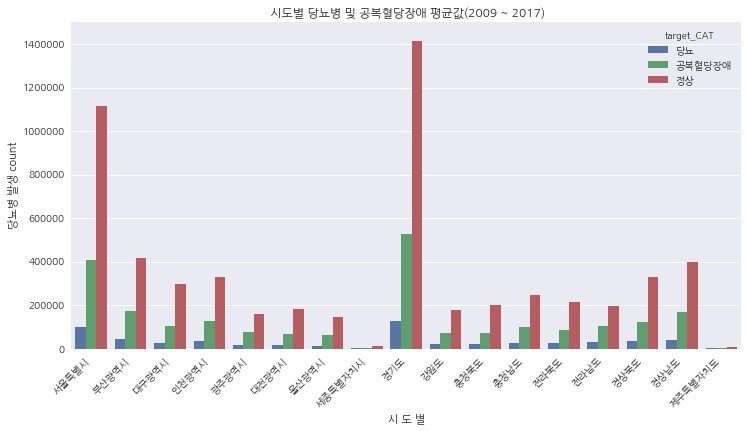

In [121]:
temp_dict={'target_count': (650,1500000)}
def Plot(df):
    for column, tup in temp_dict.items():
        plt.figure(figsize=(12,6))
    #     fig, ax =plt.figure(figsize=(8,4))
        sns.set(font_scale=1.0)
        
#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() 
#         mpl.rc('font', family=font_name) # ahronbd.ttf
        
           # 한글깨짐 리눅스
        mpl.rcParams['font.family'] = 'NanumGothic'
        mpl.rc('axes', unicode_minus=False)

        ax = sns.barplot(x=df.index, y=column, data=df, hue='target_CAT')
        start, end = tup
        ax.set_ylim(start, end)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right') 
        ax.set_xlabel('시 도 별')
        ax.set_ylabel('당뇨병 발생 count')
        plt.title(f' 시도별 당뇨병 및 공복혈당장애 평균값(2009 ~ 2017)')
        plt.savefig(f"./img/visual/diabete_sido.png", dpi=100, bbox_inches='tight')
#         fig.savefig(out_fname,dpi=200,facecolor=fig.get_facecolor(),transparent=True,bbox_inches='tight')
        plt.show()
    #     plt.close()
Plot(df_13)

In [112]:
df.columns

Index(['기준년도', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레',
       '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
       '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부', '구강검진수검여부',
       'target', 'target_CAT', '시도코드_CAT', '연령대_CAT', '성별_CAT', '흡연상태_CAT',
       '음주여부_CAT', '구강검진수검_CAT', '청력(좌)_CAT', '청력(우)_CAT', 'W', 'H', 'BMI',
       'BMI_CAT'],
      dtype='object')

In [114]:
df_333 = df.groupby(['성별_CAT','target', 'target_CAT'])[['target']].count()
df_333.columns = ['target_count']
df_333 = df_333.reset_index()
# df_11['target_count'].sort_values(ascending=True)
df_333 = df_333.set_index('성별_CAT')
df_333.head(10)

,target,target_CAT,target_count
성별_CAT,,,
남자,1,당뇨,376469
남자,2,공복혈당장애,1410764
남자,3,정상,2940245
여자,1,당뇨,203298
여자,2,공복혈당장애,889977
여자,3,정상,2947150


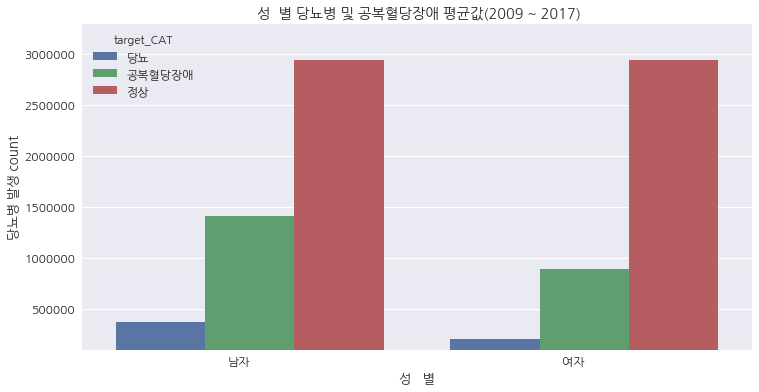

In [122]:
temp_dict={'target_count': (100000,3300000)}
def Plot(df):
    for column, tup in temp_dict.items():
        plt.figure(figsize=(12,6))
    #     fig, ax =plt.figure(figsize=(8,4))
        sns.set(font_scale=1.2)
        
#         font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() 
#         mpl.rc('font', family=font_name) # ahronbd.ttf
        
           # 한글깨짐 리눅스
        mpl.rcParams['font.family'] = 'NanumGothic'
        mpl.rc('axes', unicode_minus=False)

        ax = sns.barplot(x=df.index, y=column, data=df, hue='target_CAT')
        start, end = tup
        ax.set_ylim(start, end)
        ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='right') 
        ax.set_xlabel('성   별')
        ax.set_ylabel('당뇨병 발생 count')
        plt.title(f' 성  별 당뇨병 및 공복혈당장애 평균값(2009 ~ 2017)')
        plt.savefig(f"./img/visual/diabete_sex.png", dpi=100, bbox_inches='tight')
#         fig.savefig(out_fname,dpi=200,facecolor=fig.get_facecolor(),transparent=True,bbox_inches='tight')
        plt.show()
    #     plt.close()
Plot(df_333)